In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util, transform
from PIL import Image

# 1. Entrene una red de Hopfield ‘82 con un conjunto de imágenes binarias.

Recordatorios de tamaños

El vector de la imagen original aplanada → (N,).

El vector de la imagen con ruido (x0) → (N,).

La matriz de pesos W → (N, N).

Todas las imagenes tienen que tener el mismo tamaño

1. Preprocesar los patrones. Las imagenes son binarias, están en 0 (negro) y 1/255 (blanco).

    Las redes de Holpfield trabajan con +1/-1

    Tengo que aplicar una función signo que se aplique a cada imagen. 

2. Aplanar los patrones
    La red Hopfield funciona con vectores de tamaño N (uno por neurona).

    Si la imagen es de 28x28, el vector tendrá 784 entradas.
    Convierto una matriz de 3D o 2D a un vector de 1D

In [ ]:
import numpy as np
from PIL import Image

def preparar_patterns(img_list: list, size=(45,60)) -> np.ndarray:
    img_aplanadas_vec = []
    for arr in img_list:
        img = Image.fromarray(arr).convert("L")
        img = img.resize(size, resample=Image.NEAREST)
        arr = np.array(img, dtype=np.uint8)          

        threshold = 200
        bin01 = (arr < threshold).astype(np.uint8)
        signo = (bin01 * 2 - 1).astype(np.int8)
        vec = signo.reshape(-1)
        img_aplanadas_vec.append(vec)

    patterns = np.stack(img_aplanadas_vec)
    return patterns

In [3]:
def calcular_matriz_conn(patterns):
    P, N = patterns.shape
    W = np.zeros((N, N), dtype=np.float32)
    for p in patterns:
        W += np.outer(p, p)
    W /= P
    np.fill_diagonal(W, 0.0)
    return 0.5 * (W + W.T)

In [ ]:
def agg_ruido_img(img_1d: np.ndarray, frac: float, rng=None) -> np.ndarray:
    rng = rng or np.random.default_rng()
    x = img_1d.reshape(-1)  
    y = x.copy()
    k = int(round(frac * x.size))
    if k > 0:
        idx = rng.choice(x.size, k, replace=False)
        y[idx] *= -1
    return y


import numpy as np

def borrar_img(vec: np.ndarray, frac: float, shape: tuple, axis: str = "cols") -> np.ndarray:
    """
    Borra un porcentaje de la imagen (pone -1 en esa región).
    
    vec   : patrón 1D en {-1,+1}
    frac  : fracción a borrar (0..1)
    shape : (alto, ancho) de la imagen
    axis  : "cols" para columnas, "rows" para filas
    
    Devuelve: nuevo vector 1D con parte borrada
    """
    img = vec.reshape(shape).copy()

    H, W = shape
    if axis == "cols":
        n_cols = int(W * frac)
        img[:, -n_cols:] = -1
    elif axis == "rows":
        n_rows = int(H * frac)
        img[-n_rows:, :] = -1
    else:
        raise ValueError("axis debe ser 'cols' o 'rows'")

    return img.reshape(-1)


In [5]:
def mostrar_patron(vec, shape, titulo=""):
    """
    vec   : patrón 1D en {-1,+1}
    shape : (alto, ancho) de la imagen
    """
    img = vec.reshape(shape)
    # mapear {-1,1} a {255,0} → blanco/negro
    img = ((-img + 1) * 127.5).astype(np.uint8)

    plt.imshow(img, cmap="gray")
    plt.title(titulo)
    plt.axis("off")

In [6]:
def update_sync(s, W):
    s = s.reshape(-1).astype(np.int8)
    h = W @ s
    out = np.sign(h).astype(np.int8)
    out[out == 0] = s[out == 0]
    return out

def update_async(s, W):
    y = s.reshape(-1).copy().astype(np.int8)
    N = y.size
    for i in np.random.permutation(N):
        h_i = np.dot(W[i, :], y)
        if   h_i > 0: y[i] =  1
        elif h_i < 0: y[i] = -1
    return y


def Hopfield_train(x0: np.ndarray, W: np.ndarray, mode: str = "async"):
    s = x0.copy()
    sweeps = 0
    if mode == "async":
        while True:
            sweeps += 1
            s_new = update_async(s, W)
            if np.array_equal(s_new, s):
                return s_new, sweeps, True, False
            s = s_new
    elif mode == "sync":
        s_prev = None
        while True:
            sweeps += 1
            s_new = update_sync(s, W)
            if np.array_equal(s_new, s):
                return s_new, sweeps, True, False
            if s_prev is not None and np.array_equal(s_new, s_prev):
                return s_new, sweeps, True, True
            s_prev, s = s, s_new
    else:
        raise ValueError("mode debe ser 'async' o 'sync'")


#### Selecciono a las imagenes con el tamaño de (45, 60) y hago el primer entrenamiento de la red

# Punto a

In [ ]:
import os
images = []
images_shape = []
#files = ['dataset/paloma.bmp', 'dataset/panda.bmp', 'dataset/perro.bmp',
#         'dataset/quijote.bmp', 'dataset/torero.bmp', 'dataset/v.bmp']
files = ['dataset/paloma.bmp','dataset/quijote.bmp', 'dataset/torero.bmp']

for data in files:
    if '.bmp' in data:
        image = io.imread(data)
        images.append(image)
        images_shape.append(image.shape)
images_shape = list(set(images_shape))
print(images_shape)

In [ ]:
images_train = [] 
for image in images:
    if image.shape == images_shape[0]:
        images_train.append(image)

In [ ]:
images_train

In [ ]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))  # PIL usa (W,H)

W_hopfield = calcular_matriz_conn(patterns)


In [ ]:
patterns

In [ ]:
x0 = patterns[0].copy()  # vector ±1
# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0, W_hopfield, mode="async")

In [ ]:
H, W = images_shape[0]   
x0_img = x0.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x0_img, (H, W), "Patrón inicial")

plt.subplot(1,2,2)
mostrar_patron(s_final, (H, W), "Imagen recuperada")

plt.show()

# Punto b (Le agrego ruido a las imagenes)

In [ ]:
import os
images = []
images_shape = []
files = ['dataset/panda.bmp', 'dataset/perro.bmp', 'dataset/v.bmp']

for data in files:
    if '.bmp' in data:
        image = io.imread(data)
        images.append(image)
        images_shape.append(image.shape)
images_shape = list(set(images_shape))
print(images_shape)

In [ ]:
images_train = [] 
for image in images:
    if image.shape == images_shape[0]:
        images_train.append(image)

In [ ]:
images_train

In [ ]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))  
W_hopfield = calcular_matriz_conn(patterns)
x0 = patterns[2].copy()  # vector ±1
x0_ruido = agg_ruido_img(x0, 0.2)
# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0_ruido, W_hopfield, mode="async")


In [ ]:
H, W = images_shape[0]   
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.subplot(1,2,1)
mostrar_patron(x0_ruido, (H, W), "Patrón con ruido")

plt.show() 

In [ ]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))  
W_hopfield = calcular_matriz_conn(patterns)
x0 = patterns[0].copy()  # vector ±1
x0_borrado = borrar_img(x0, 0.9, (H, W), axis="cols")
# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0_borrado, W_hopfield, mode="async")

In [ ]:
H, W = images_shape[0]   
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x0_borrado, (H, W), "Patrón Borrado")

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.show() 

# Punto C

In [ ]:
import os
images = []
images_shape = []
files = ['dataset/panda.bmp', 'dataset/perro.bmp', 'dataset/v.bmp']

for data in files:
    if '.bmp' in data:
        image = io.imread(data)
        images.append(image)
        images_shape.append(image.shape)
images_shape = list(set(images_shape))
print(images_shape)

In [ ]:
images_train = [] 
for image in images:
    if image.shape == images_shape[0]:
        images_train.append(image)

In [ ]:
H, W = images_shape[0]
patterns = preparar_patterns(images_train, size=(W, H))
W_hopfield = calcular_matriz_conn(patterns)

In [ ]:
x0 = patterns[2].copy()  # vector ±1
x0_inverso = -x0

In [ ]:

# correr Hopfield
s_final, sweeps, converged, two_cycle = Hopfield_train(x0_inverso, W_hopfield, mode="async")

In [ ]:
H, W = images_shape[0]   
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x0_inverso, (H, W), "Patrón inverso presentado")

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.show() 

In [ ]:
x_mix = np.sign(patterns[0] + patterns[1] + patterns[2]).astype(np.int8)

In [ ]:
s_final, sweeps, conv, cycle = Hopfield_train(x_mix, W_hopfield, mode="async")

In [ ]:
H, W = images_shape[0]   
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x_mix, (H, W), "Patrón combinado presentado")

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.show() 

# Punto d

In [ ]:
from PIL import Image
import numpy as np
from skimage import io  # si ya lo estabas usando

# --- helper: redimensiona manteniendo aspecto y completa con blanco a 50x50 ---
def normalize_to_box(arr: np.ndarray, box=(50, 50)) -> np.ndarray:
    """
    arr: imagen como np.array (grises o RGB)
    box: (W, H) tamaño destino
    return: np.array uint8 (H, W) 50x50 en gris, con padding blanco si hace falta
    """
    Wt, Ht = box
    img = Image.fromarray(arr).convert("L")
    w, h = img.size
    scale = min(Wt / w, Ht / h)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    img_res = img.resize((new_w, new_h), resample=Image.NEAREST)

    canvas = Image.new("L", (Wt, Ht), color=255)   # fondo blanco
    off_x = (Wt - new_w) // 2
    off_y = (Ht - new_h) // 2
    canvas.paste(img_res, (off_x, off_y))
    return np.array(canvas, dtype=np.uint8)


import os
images = []
images_shape = []
files = ['dataset/panda.bmp', 'dataset/perro.bmp', 'dataset/v.bmp',
         'dataset/paloma.bmp','dataset/quijote.bmp', 'dataset/torero.bmp']

for path in files:
    if path.endswith('.bmp'):
        img = io.imread(path)
        images.append(img)
        images_shape.append(img.shape)

images_shape = list(set(images_shape))
print(images_shape)

# Normalizo TODAS a 50x50 
images_train = [normalize_to_box(img, box=(50, 50)) for img in images]


In [ ]:
patterns = preparar_patterns(images_train, size=(50, 50))  
W_hopfield = calcular_matriz_conn(patterns)

In [ ]:
x0 = patterns[5].copy()  # vector ±1
s_final, sweeps, conv, cycle = Hopfield_train(x0, W_hopfield, mode="async")

In [ ]:
H, W = 50, 50  
x0_img = s_final.reshape(H, W)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
mostrar_patron(x0, (H, W), "Patrón presentado")

plt.subplot(1,2,2)
mostrar_patron(x0_img, (H, W), "Patrón recuperado")

plt.show() 

# 2a

In [ ]:
import numpy as np
import pandas as pd

# uso la misma update_sync
def update_sync(s, W):
    s = s.reshape(-1).astype(np.int8)
    h = W @ s
    out = np.sign(h).astype(np.int8)
    out[out == 0] = s[out == 0]
    return out

def hopfield82_weights(patterns: np.ndarray) -> np.ndarray:
    X = patterns.astype(np.float32)
    N = X.shape[1]
    W = (X.T @ X) / float(N)
    np.fill_diagonal(W, 0.0)
    return W

def perr_one_pass(W: np.ndarray, patterns: np.ndarray) -> float:
    flips = 0
    total = patterns.size
    for x in patterns:
        x1 = update_sync(x, W)      
        flips += np.count_nonzero(x1 != x)
    return flips / total

def calcular_tabla_capacidad(p_errors, n=10, trials=100, seed=0):
    """
    p_errors: lista de umbrales P_error
    n       : lado de la imagen (N = n*n)
    trials  : cantidad de corridas por umbral 
    """
    rng_master = np.random.default_rng(seed)
    N = n * n
    out_rows = []

    for perr_target in p_errors:
        Cs = []
        for _ in range(trials):
            rng = np.random.default_rng(rng_master.integers(0, 2**31-1))
            patterns = []                     
            E = 0.0
            while E < perr_target:
                x = rng.integers(0, 2, size=N, dtype=np.int8) * 2 - 1
                patterns.append(x)

                X = np.stack(patterns, axis=0)     
                W = hopfield82_weights(X)
                E = perr_one_pass(W, X)
            C = (len(patterns) - 1) / N
            Cs.append(C)

        out_rows.append({
            "P_error": perr_target,
            "P_max_N": float(np.mean(Cs))
        })

    df = pd.DataFrame(out_rows).set_index("P_error")
    return df

p_error = [0.001, 0.0036, 0.01, 0.05, 0.1]
tabla = calcular_tabla_capacidad(p_error, n=10, trials=20, seed=42)  


In [8]:
tabla.reset_index()

,P_error,P_max_N
0,0.0010,0.1155
1,0.0036,0.1410
2,0.0100,0.1840
3,0.0500,0.3770
4,0.1000,0.6140


# 2b

In [9]:
def generar_patrones_correlados(P, N, proba=0.1, rng=np.random.default_rng()):
    """
    Genera P patrones de longitud N con correlación controlada.
    proba: probabilidad de cambiar cada bit respecto al patrón base.
    """
    base = rng.choice([-1, 1], size=N)   # patrón base aleatorio
    patterns = [base]
    for _ in range(P-1):
        mask = rng.random(N) < proba
        nuevo = base.copy()
        nuevo[mask] *= -1
        patterns.append(nuevo)
    return np.array(patterns)


In [10]:
patterns = generar_patrones_correlados(P=5, N=100, proba=0.1)
print(patterns.shape)   # (5, 100)
print(patterns[0])      # patrón base
print(patterns[1])      # un patrón derivado


(5, 100)
[ 1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1  1  1
 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1  1 -1
 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1  1  1
  1 -1 -1 -1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1
  1 -1  1 -1]
[ 1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1
  1 -1  1 -1 -1 -1  1  1 -1  1  1  1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1 -1
 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1  1 -1 -1  1 -1
  1 -1 -1 -1  1 -1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1
  1 -1  1 -1]


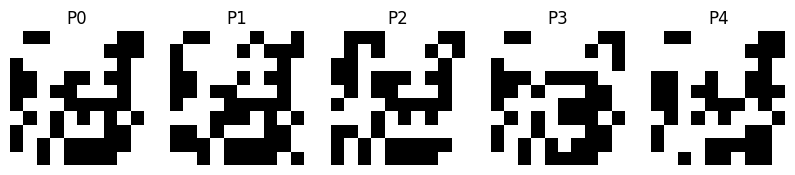

In [11]:
import matplotlib.pyplot as plt

patterns = generar_patrones_correlados(P=5, N=100, proba=0.1)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    img = patterns[i].reshape(10, 10)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"P{i}")
plt.show()


In [28]:
import numpy as np
import pandas as pd


probas = [0.0, 0.05, 0.1, 0.2, 0.5]
N = 1000
perr_target = 0.0036

resultados = []
for p in probas:
    E = 0.0
    P = 0
    while E < perr_target and P < 100:
        P += 1
        patrones = generar_patrones_correlados(P, N, proba=p)
        W = hopfield82_weights(patrones)
        E = perr_one_pass(W, patrones)
    C = (P-1)/N
    resultados.append({"proba": p, "C = p_max/N": C})

tabla = pd.DataFrame(resultados).set_index("proba")

In [29]:
tabla.reset_index()

,proba,C = p_max/N
0,0.00,0.099
1,0.05,0.002
2,0.10,0.002
3,0.20,0.002
4,0.50,0.099


# Extra

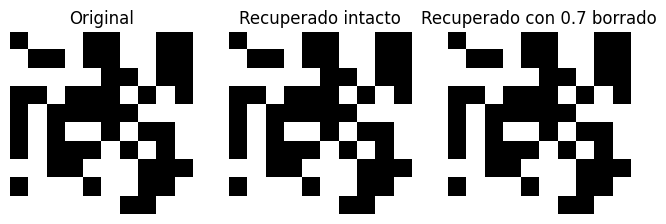

In [ ]:
import matplotlib.pyplot as plt


n = 10       
N = n * n
P = 3        # cantidad de patrones
rng = np.random.default_rng(1)
porc_borrado = 0.7


patterns = rng.choice([-1, 1], size=(P, N))


W = hopfield82_weights(patterns)


def eliminar_conexiones(W, porc_borrar, rng=np.random.default_rng()):
    Wc = W.copy()
    mask = rng.random(W.shape) < porc_borrar
    Wc[mask] = 0.0
    return Wc

W_corrupto = eliminar_conexiones(W, porc_borrar=porc_borrado)

x0 = patterns[0]

rec_intacto = update_sync(x0, W)
rec_corrupto = update_sync(x0, W_corrupto)

def mostrar(ax, vec, n, titulo):
    img = vec.reshape(n, n)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(titulo)

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
mostrar(axes[0], x0, n, "Original")
mostrar(axes[1], rec_intacto, n, "Recuperado intacto")
mostrar(axes[2], rec_corrupto, n, f"Recuperado con {porc_borrado} borrado")
plt.show()


In [ ]:
fracs = [0.0, 0.3, 0.5, 0.7, 0.85, 0.95]
n = 10
N = n*n
P = 12  # numero de patrones distintos que se almacenan en la red
rng = np.random.default_rng(0)


patterns = rng.choice([-1, 1], size=(P, N))
W = hopfield82_weights(patterns)

def eliminar_conexiones(W, frac, rng=np.random.default_rng()):
    Wc = W.copy()
    mask = rng.random(W.shape) < frac
    Wc[mask] = 0.0
    return Wc

for f in fracs:
    Wc = eliminar_conexiones(W, f, rng)
    E = perr_one_pass(Wc, patterns)
    print(f"borrado={f:.2f} -> P_error={E:.4f}")

borrado=0.00 -> P_error=0.0008
borrado=0.30 -> P_error=0.0017
borrado=0.50 -> P_error=0.0158
borrado=0.70 -> P_error=0.0367
borrado=0.85 -> P_error=0.1183
borrado=0.95 -> P_error=0.2067


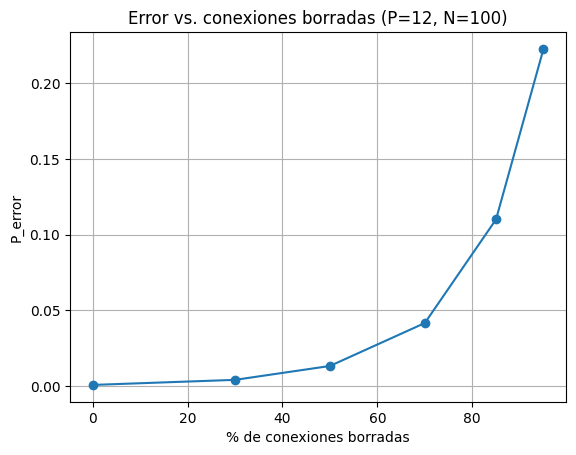

In [38]:
import matplotlib.pyplot as plt

fracs = [0.0, 0.3, 0.5, 0.7, 0.85, 0.95]
errors = []

for f in fracs:
    Wc = eliminar_conexiones(W, f, rng)
    E = perr_one_pass(Wc, patterns)
    errors.append(E)

plt.plot([f*100 for f in fracs], errors, marker="o")
plt.xlabel("% de conexiones borradas")
plt.ylabel("P_error")
plt.title(f"Error vs. conexiones borradas (P={P}, N={N})")
plt.grid(True)
plt.show()


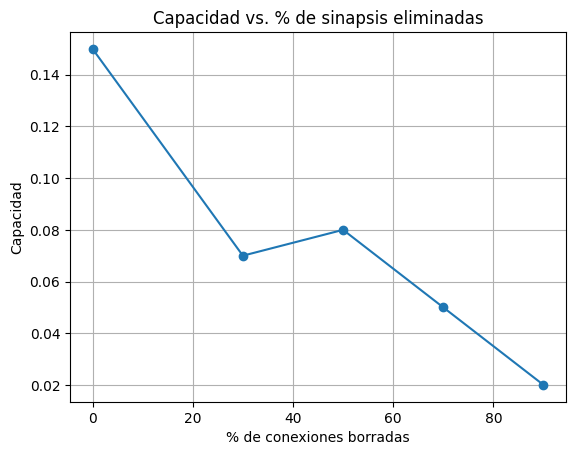

In [ ]:
import matplotlib.pyplot as plt

fracs = [0.0, 0.3, 0.5, 0.7, 0.9]
N = 100
perr_target = 0.0036
rng = np.random.default_rng(0)

def capacidad_con_borrado(N, frac, perr_target, rng):
    E = 0.0
    P = 0
    while E < perr_target and P < 80: 
        P += 1
        patterns = rng.choice([-1, 1], size=(P, N))
        W = hopfield82_weights(patterns)
        mask = rng.random(W.shape) < frac
        W[mask] = 0.0
        E = perr_one_pass(W, patterns)
    return (P-1)/N

capacidades = []
for f in fracs:
    C = capacidad_con_borrado(N, f, perr_target, rng)
    capacidades.append(C)

plt.plot([f*100 for f in fracs], capacidades, marker="o")
plt.xlabel("% de conexiones borradas")
plt.ylabel("Capacidad")
plt.title("Capacidad vs. % de sinapsis eliminadas")
plt.grid(True)
plt.show()
